# One-way ANOVA with Variance-Stabilizing Transformations

## 背景描述

这里对五种绝缘材料的性能进行实验研究。我们在升高电压的情况下对每种材料的四个样本进行测试，以加速失效时间。
这是一个因子水平数 𝑎 = 5 和重复次数 𝑛 = 4 的单因子实验。

## 数据描述

|         变量名         |   变量含义   |             变量类型              |  变量取值范围   |
| :--------------------: | :----------: | :-------------------------------: | :-------------: |
|   （自变量）Material   | 绝缘材料类型 |       categorical variable        | [1, 2, 3, 4, 5] |
| （因变量）Failure Time |   失效时间   | continuous variable（单位：分钟） |      Real       |



## 问题 

注：这里使用 \alpha=0.05 的显著性水平

1. 试判断 5 种绝缘材料的性能是否存在差异.
2. 试判断该实验数据是否满足方差齐性.
3. 若实验中的数据不满足方差齐性，试判断失效时间如何进行方差稳定化变换.
4. 如果需要变换，基于变换后的数据，试判断 5 种绝缘材料的性能是否存在差异.

## 解决方案

**Q1:**  
检验假设 $H_0: \mu_1 = \mu_2 = \mu_3 = \mu_4 = \mu_5$ ;  $H_1: \mu_1, \mu_2, \mu_3, \mu_4, \mu_5$不全相等

In [1]:
# Import standard packages
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import special
import matplotlib.pyplot as plt
import math

# Import additional packages
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f

alpha = 0.05
a = 5
n = 4

x = pd.read_csv("data/Project2.csv")
data = x.values[:,1:3]
print(data)

[[    1   110]
 [    1   157]
 [    1   194]
 [    1   178]
 [    2     1]
 [    2     2]
 [    2     4]
 [    2    18]
 [    3   880]
 [    3  1256]
 [    3  5276]
 [    3  4355]
 [    4   495]
 [    4  7040]
 [    4  5307]
 [    4 10050]
 [    5     7]
 [    5     5]
 [    5    29]
 [    5     2]]


In [2]:
# Sort them into groups, according to column 1("Method")
group1 = data[data[:,0] == 1,1]
group2 = data[data[:,0] == 2,1]
group3 = data[data[:,0] == 3,1]
group4 = data[data[:,0] == 4,1]
group5 = data[data[:,0] == 5,1]

# Do the one-way ANOVA
df = pd.DataFrame(data, columns = ['material', 'ftime'])   
model = ols('ftime ~ C(material)', df).fit()
anovaResults = round(anova_lm(model), 2)
print('The ANOVA table: \n', anovaResults)

F0, pVal1 = stats.f_oneway(group1, group2, group3, group4, group5)
# 法1：
# print(pVal1)
if pVal1 < alpha:
    print('\nSince p-value < 0.05, reject H0.')
else:
    print('\nAccept H0.') 
    
# 法2：
F = round(f.ppf(0.95,dfn = 4,dfd = 15), 2)
if F0 > F:
    print('Since F0 > F(0.05, 3, 20) = ', F, ', reject H0.')
else:
    print('Accept H0.') 

The ANOVA table: 
                df       sum_sq     mean_sq     F  PR(>F)
C(material)   4.0  103191489.2  25797872.3  6.19     0.0
Residual     15.0   62505657.0   4167043.8   NaN     NaN

Since p-value < 0.05, reject H0.
Since F0 > F(0.05, 3, 20) =  3.06 , reject H0.


In [3]:
print(F0)
print(pVal1)

6.190928998634478
0.0037859562963802845


由方差分析表可知，P值小于 0.05 且F值大于 3.06，故拒绝原假设，即 5 种绝缘材料的性能存在差异。

**Q2:**  
ANOVA模型： 
$y_{ij} = \mu + \tau_i + \epsilon_{ij}$ 的误差服从正态独立分布，其均值为零，方差为未知的常数$\sigma^2$。 
想要判断ANOVA模型是否恰当，可以利用残差检测来进行分析。  
处理 $i$ 的观测值 $j$ 的残差定义为：$e_{ij} = y_{ij} - \hat{y}_{ij}$  
其中$\hat{y}_{ij}$是对应于$y_{ij}$的一个估计， 
$\hat{y}_{ij} = \hat{\mu} + \hat{\tau}_i = \overline{y}_{··} + (\overline{y}_{i·} - \overline{y}_{··}) = \overline{y}_{i·}$  
检验假设：$𝐻_0:\sigma_1^2 = \sigma_2^2 = ⋯ = \sigma_a^2$  vs $𝐻_1:\sigma_i^2 \neq \sigma_j^2, ∃ i \neq j$  
不满足方差齐性的判断依据：

In [4]:
# 计算残差
data_res = data.astype(float) * 1
for k in range(a):
    cnt = data_res[data_res[:,0] == k + 1,1]
    data_res[data_res[:,0] == k + 1,1] = cnt - np.mean(cnt)
# print(data_res)

Text(0, 0.5, 'e_ij')

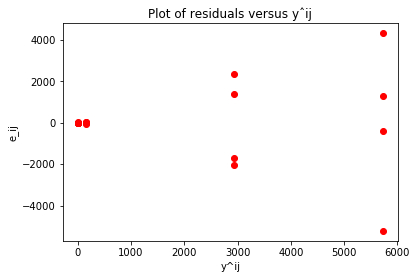

In [5]:
# 法1：残差与拟合值的关系图
res = data_res[:,1]
y = []
for i in range(a):
    for j in range(n):
        y.append(np.mean(data[(data[:,0] == i + 1),1]))
plt.scatter(y, res, c = "red")
plt.title('Plot of residuals versus yˆij')
plt.xlabel('y^ij')
plt.ylabel('e_ij')

In [6]:
# 法2：用Bartlett检验进行方差齐性检验
bart, pVal2 = stats.bartlett(group1, group2, group3, group4, group5)
bart_stat = stats.chi2.isf(alpha, a - 1)
print('Bartlett检验的P值为：', round(pVal2, 4))
if pVal2 < alpha:
    print('Since p-value < 0.05, reject H0.')
else:
    print('Accept H0')  

Bartlett检验的P值为： 0.0
Since p-value < 0.05, reject H0.


In [7]:
# 法3：用Levene检验进行方差齐性检验
lene, pVal3 = stats.levene(group1, group2, group3, group4, group5)
print('\nLevene检验的P值为：', round(pVal3, 4))
if pVal3 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n')  


Levene检验的P值为： 0.0043
Since p-value < 0.05, reject H0.



由分析可知:  
1. 残差与拟合值的关系图：呈现开口向外的漏斗型，说明方差随均值的增加而增大；
2. Bartlett 检验法：P值为 0.0 < 0.05；
3. Levene检验法：P值为 0.0043 < 0.05.  

结论：拒绝满足方差齐性的原假设。

**Q3:**  
由第二题的结论可知，实验数据不满足方差齐性。为了研究失效时间如何采用方差稳定化变换，需画出$logS_i$和$log\overline{y}_{i·}$的关系图。

斜率为： 0.92


Text(0, 0.5, 'log_Si')

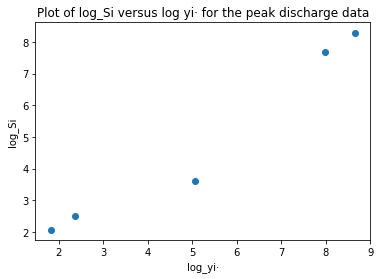

In [8]:
# 求出各估计方法的标准差sigma_i和均值mu_i的对数
# 通常用样本的标准差std_i和均值y_i代替总体的标准差sigma_i和均值mu_i
log_y_1 = math.log(np.mean(group1))
log_y_2 = math.log(np.mean(group2))
log_y_3 = math.log(np.mean(group3))
log_y_4 = math.log(np.mean(group4))
log_y_5 = math.log(np.mean(group5))
log_y = [log_y_1, log_y_2, log_y_3, log_y_4, log_y_5]

log_std_1 = math.log(np.std(group1, ddof = 1))
log_std_2 = math.log(np.std(group2, ddof = 1))
log_std_3 = math.log(np.std(group3, ddof = 1))
log_std_4 = math.log(np.std(group4, ddof = 1))
log_std_5 = math.log(np.std(group5, ddof = 1))
log_std = [log_std_1, log_std_2, log_std_3, log_std_4, log_std_5]

# linregress(x,y)线性回归函数
slope, intercept, r_value, p_value, std_err = stats.linregress(log_y, log_std)
print('斜率为：', round(slope, 2))

# 作图
plt.scatter(log_y, log_std)
plt.title('Plot of log_Si versus log yi· for the peak discharge data')
plt.xlabel('log_yi·')
plt.ylabel('log_Si')


过这 5 点的直线斜率为 $0.92$ ，即 $\alpha= 0.92$。根据 $\lambda = 1−\alpha，\lambda = 0.08$。变换后的数据为 $𝑦^* = y^{0.08}$ 。

或者取$\lambda = 0.1$，则变换后的数据为$𝑦^* = y^{0.1}$，这里不用这种近似方法。

Text(0, 0.5, 'e_ij*')

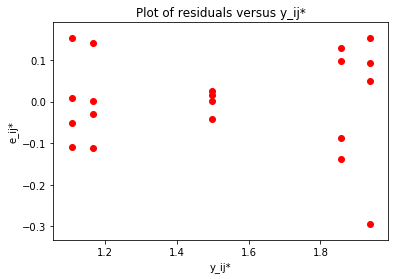

In [9]:
# 计算y**0.08进行方差稳定化变换
s_group1 = group1 ** 0.08
s_group2 = group2 ** 0.08
s_group3 = group3 ** 0.08
s_group4 = group4 ** 0.08
s_group5 = group5 ** 0.08
s_groups = [s_group1, s_group2, s_group3, s_group4, s_group5]
s_groups1 = pd.DataFrame(s_groups)


# 计算变换后的残差
df = np.array(s_groups)
s_data = [data[:,0], df.reshape(1, 20).tolist()[0]]
s_data = np.array(s_data * 1).T
s_data_res = s_data * 1
for k in range(a):
    s_cnt = s_data_res[s_data_res[:,0] == k + 1,1]
    s_data_res[s_data_res[:,0] == k + 1,1] = s_cnt - np.mean(s_cnt)

# 变换后的残差与拟合值的关系图
s_res = s_data_res[:,1]
s_y = []
for i in range(a):
    for j in range(n):
        s_y.append(np.mean(s_data[(s_data[:,0] == i + 1),1]))
plt.scatter(s_y, s_res, c = "red")
plt.title('Plot of residuals versus y_ij*')
plt.xlabel('y_ij*')
plt.ylabel('e_ij*')

上图为变换后的残差与拟合值的关系图

【补充】Box-Cox变换：Box-Cox变换的主要特点是引入一个参数 $\lambda$，通过数据本身估计该参数进而确定应采取的数据变换形式，Box-Cox变换可以明显地改善数据的正态性、方差齐性。  
Box-Cox变换的一般形式为：  
$$ y(\lambda)=\left\{
\begin{aligned}
\frac{(y+c)^{\lambda}-1}{\lambda} & ,&\lambda \neq 0 \\
\ln (y+c) & ,& \lambda = 0 
\end{aligned}
\right.
$$
式中$y(\lambda)$为经Box-Cox变换后得到的新变量，$y$ 为原始连续因变量，其中 $y+c$ 的 $+c$ 是为了确保 $(y+c)>0$,因为在Box-Cox变换中要求 $y>0$，$\lambda$ 为变换参数。  
在这里可以看到 $\lambda$ 的值是需要我们自己去确定的，那么怎么去确定呢？这里使用的方法是假设经过转换后的因变量就是服从正态分布的，然后画出关于 $\lambda$ 的似然函数，似然函数值最大的时候 $\lambda$ 的取值就是这里需要确定的值。

lmax_mle:  0.016756747738272192
lmax_pearsonr:  0.014405179642792882


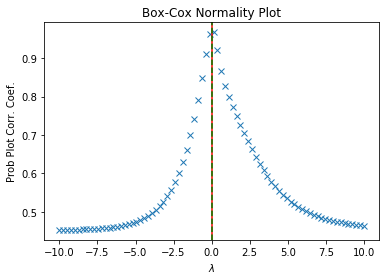

Text(0, 0.5, 'e_ij*')

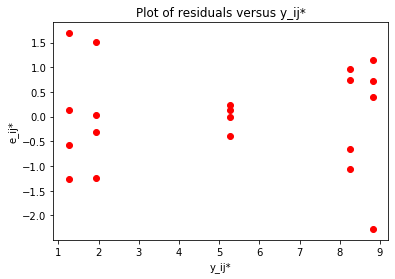

In [10]:
# 作Box-Cox变换
bc, lmax_mle = stats.boxcox(data[:,1])
lmax_pearsonr = stats.boxcox_normmax(data[:,1])
print('lmax_mle: ', lmax_mle)
print('lmax_pearsonr: ', lmax_pearsonr)

fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(data[:,1], -10, 10, plot = ax)
ax.axvline(lmax_mle, color='r')
ax.axvline(lmax_pearsonr, color='g', ls='--')
plt.show()

# 计算变换后的残差
bc_group1 = bc[0:4]
bc_group2 = bc[4:8]
bc_group3 = bc[8:12]
bc_group4 = bc[12:16]
bc_group5 = bc[16:20]
bc_groups = [bc_group1, bc_group2, bc_group3, bc_group4, bc_group5]
bc_groups1 = pd.DataFrame(bc_groups)
# print(bc_groups1)

df = np.array(bc_groups)
bc_data = [data[:,0], df.reshape(1, 20).tolist()[0]]
bc_data = np.array(bc_data * 1).T
bc_data_res = bc_data * 1
for k in range(a):
    bc_cnt = bc_data_res[bc_data_res[:,0] == k + 1,1]
    bc_data_res[bc_data_res[:,0] == k + 1,1] = bc_cnt - np.mean(bc_cnt)

# 变换后的残差与拟合值的关系图
bc_res = bc_data_res[:,1]
bc_y = []
for i in range(a):
    for j in range(n):
        bc_y.append(np.mean(bc_data[(bc_data[:,0] == i + 1),1]))
plt.scatter(bc_y, bc_res, c = "red")
plt.title('Plot of residuals versus y_ij*')
plt.xlabel('y_ij*')
plt.ylabel('e_ij*')

上图为变换后的残差与拟合值的关系图

Q4:

In [11]:
# 计算y^0.08，再用Levene检验进行方差齐性检验
s_lene, pVal4 = stats.levene(s_group1, s_group2, s_group3, s_group4, s_group5)
if pVal4 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n')  

Accept H0



In [12]:
# Box-Cox变换后，再用Levene检验进行方差齐性检验 
bc_lene, pVal5 = stats.levene(bc_group1, bc_group2, bc_group3, bc_group4, bc_group5)
if pVal5 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n') 

Accept H0



接受Levene检验的原假设，用这两种方式进行数据变换后，处理后的数据均满足方差齐性。

In [13]:
# 计算y^0.08，Do the one-way ANOVA with transformation of square root
sqrt_F0, pVal6 = stats.f_oneway(s_group1, s_group2, s_group3, s_group4, s_group5)
if pVal6 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n') 

Since p-value < 0.05, reject H0.



In [14]:
# Box-Cox变换后，Do the one-way ANOVA with transformation of square root
bc_F0, pVal7 = stats.f_oneway(bc_group1, bc_group2, bc_group3, bc_group4, bc_group5)
if pVal7 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n') 

Since p-value < 0.05, reject H0.



对用这两种方式变换后的数据进行单因素方差分析检验，拒绝原假设，即 5 种绝缘材料的性能存在差异

In [15]:
print(sqrt_F0)
print(pVal6)
print(bc_F0)
print(pVal7)

35.32243586798019
1.807988537427157e-07
37.6248973335117
1.1828444086335894e-07


具体计算方差分析表如下

In [16]:
# 计算y^0.08，Elegant alternative implementation, with pandas & statsmodels
for i in range(a):
    data = data.astype('float') #需要加这一行代码，否则差距很大
    data[0 + 4 * i:4 * (i + 1), 1] = list(s_groups[i])
df = pd.DataFrame(data, columns = ['material', 'ftime'])   
model = ols('ftime ~ C(material)', df).fit()
anovaResults = anova_lm(model)
print(anovaResults)

               df    sum_sq   mean_sq          F        PR(>F)
C(material)   4.0  2.326792  0.581698  35.322436  1.807989e-07
Residual     15.0  0.247023  0.016468        NaN           NaN


In [17]:
#Box-Cox变换后
for i in range(a):
    data = data.astype('float') #需要加这一行代码，否则差距很大
    data[0 + 4 * i:4 * (i + 1), 1] = list(bc_groups[i])
df = pd.DataFrame(data, columns = ['material', 'ftime'])   
model = ols('ftime ~ C(material)', df).fit()
anovaResults = anova_lm(model)
print(anovaResults)

               df      sum_sq    mean_sq          F        PR(>F)
C(material)   4.0  193.668327  48.417082  37.624897  1.182844e-07
Residual     15.0   19.302544   1.286836        NaN           NaN


以上其实是用两种代码方式计算检验统计量F值和p-value，可以看到两种方式得到的结果是一致的。

如果缺失data = data.astype('float')，得到的结果不一致。所以data = data.astype('float')调整数据精度是有必要的

由上结果可知，稳定化变换后的数据满足方差齐性。

再进行单因素方差分析，由方差分析表知，P值小于0.05，故拒绝原假设，即 5 种绝缘材料的性能存在差异。